Running on Quantinuum H-Series 
===============================

In this tutorial, we demonstrate how to perform a simple quantum chemical calculation on Quantinuum H-Series.

Since this tutorial focuses on practical quantum computation, we will perform a simple calculation: the single point (i.e. not optimized/not variationally solved) total energy evaluation of the H2 molecule in the Unitary Coupled Cluster (UCC) ansatz for a set value of the ansatz variational parameter.

This tutorial will require that you have access to Quantinuum backends, which can be obtained through your InQuanto administrator or contacting Quantinuum support. You will need credentials to run on a machine for a short time. For more information on Quantinuum H-Series and instructions on granting access (for administrators), see [Quantinuum H-Series page](quantinuum_hardware.rst).

The steps below are such:

- Define the system
- Perform computation with emulated hardware noise  (QuantinuumBackend emulator + machine noise profile)
- Demonstrate error mitigation methods on emulated hardware (PMSV)

### 1. Define the system 

In [ ]:
# Preload the Hamiltonian for H2
# see the Aer tutorial for details
from inquanto.express import load_h5

h2 = load_h5("h2_sto3g.h5", as_tuple=True)
hamiltonian = h2.hamiltonian_operator

from inquanto.spaces import FermionSpace
from inquanto.states import FermionState
from inquanto.symmetry import PointGroup
from inquanto.ansatzes import FermionSpaceStateExpChemicallyAware

# Define fermion space, state, and map the fermionic operator to qubits
space = FermionSpace(
    4, point_group=PointGroup("D2h"), orb_irreps=["Ag", "Ag", "B1u", "B1u"]
)

state = FermionState([1, 1, 0, 0])
qubit_hamiltonian = hamiltonian.qubit_encode()

exponents = space.construct_single_ucc_operators(state)
## the above adds nothing due to the symmetry of the system
exponents += space.construct_double_ucc_operators(state)
# Construct an efficient ansatz
ansatz = FermionSpaceStateExpChemicallyAware(exponents, state)

p = ansatz.state_symbols.construct_from_array([0.4996755931358105])
print(p)

# Import an InQuanto Computable for measuring an expecation value. 
# The operator is the qubit Hamiltonian, and the wavefunction is the ansatz.
from inquanto.computables import ExpectationValue

print(hamiltonian)
expectation0 = ExpectationValue(ansatz, hamiltonian.qubit_encode())

# Analyze the ansatz circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket import Circuit, OpType

render_circuit_jupyter(ansatz.get_circuit(p))  # this is the uncompiled ansatz circuit

print("2-qubit GATES:  {}".format(ansatz.circuit_resources()['gates_2q'])
print(ansatz.state_circuit)

   ordering symbol     value
0         0     d0  0.499676



CNOT GATES:  4
<tket::Circuit, qubits=4, gates=31>


### 2. Machine emulation for quantum noise 

Running emulator experiments before hardware experiments is a crucial step in the development and optimization of quantum algorithms and applications. Emulators provide a controlled environment where one can fine-tune algorithms, explore error mitigation strategies, and gain valuable insights about the behavior of quantum circuits without some constraints of physical hardware.

Below, we provide instructions for conducting experiments utilizing a Quantinuum H-series emulator. To utilize hardware instead of the emulator one only needs to change their choice of device when instantiating the `QuantinuumBackend`. 

<font color='red'> Note that we use the `pytket-quantinuum` extension to access a Quantinuum backend.</font>

`QuantinuumBackend` is a pytket backend that calls an H-series device ("H1-1", "H1-2") or its emulator with the corresponding noise profile ("H1-1E", "H2-1E"). The emulators are run remotely on a server. Accessing the backend retrieves information from your Quantinuum account. More information can be found on the [pytket-quantinuum page.](https://docs.quantinuum.com/tket/extensions/pytket-quantinuum/)

For comparison in the figure below, we have also plotted the exact energy (-0.5876463677224993 Ha) for H$_2$ and the user should also compare these results to result from the first part of this tutorial.

In [ ]:
from pytket.extensions.quantinuum import QuantinuumBackend

# Initialize the backend, make sure to login with your credentials. 
# Change the machine name and add the label and the group if necessary.
machine = "H1-1E"
backend = QuantinuumBackend(device_name=machine, group="")

# The QuantinuumBackend has additional arguements for accessing resources and labelling circuits
# label (Optional[str], optional) – Job labels used if Circuits have no name, defaults to “job”
# group (Optional[str], optional) – string identifier of a collection of jobs, can be used for usage tracking.

# Running the next line (device_state) will require logging into your 
# quantinuum account. This can also be called with backend.login()
print(machine, "status:", QuantinuumBackend.device_state(device_name=machine))

H1-1E status: online


In [ ]:
from inquanto.protocols import PauliAveraging
from pytket.partition import PauliPartitionStrat

# here we demonstrate building the 
protocol = PauliAveraging(
    backend,
    shots_per_circuit=10,
    pauli_partition_strategy=PauliPartitionStrat.CommutingSets,
)
protocol.build(p, ansatz, hamiltonian.qubit_encode())
protocol.compile_circuits()

# you can inspect compiled measurement circuits contained in the protocol that was run on the backend
# note that the gateset of this circuit is different to the ansatz 

render_circuit_jupyter(protocol.get_circuits()[1])


In [ ]:
# now we loop over different numbers of shots to examine convergence 
# the protocols are built, run, and the expectation values collected
set_shots = [10, 50, 100, 500, 1000, 5000, 10000]
noisy_H1_1E_energies = []

for i in set_shots:
    protocol = PauliAveraging(
        backend,
        shots_per_circuit=i,
        pauli_partition_strategy=PauliPartitionStrat.CommutingSets,
    )
    protocol.build(p, ansatz, hamiltonian.qubit_encode())
    protocol.compile_circuits()
    protocol.run()  # no seeding H series, returns results to the protocol
    noisy_H1_1E_expectation = protocol.evaluate_expectation_value(
        ansatz, hamiltonian.qubit_encode()
    )
    noisy_H1_1E_energies.append(noisy_H1_1E_expectation)

The Quantinuum Portal can be used to inspect your submitted job progress and other details as illustrated below. 

| Status    | JobID                            | Name            | MACHINE | Group     | Submit Date      | Start Date       | Result Date      | Shots |      | Cost |
|-----------|----------------------------------|-----------------|---------|-----------|------------------|------------------|------------------|-------|------|------|
| queued    | 3049eb4cf05746ffb271c8bf11cd6e91 | GQ4WEZBUGM3DI,1 | H1-1E   | UserGroup | 29/11/2023 11:42 |                  |                  | 10000 |      | 251  |
| queued    | 474e5da741a34c5b9ad0b577db0141a0 | GQ4WEZBUGM3DI,0 | H1-1E   | UserGroup | 29/11/2023 11:42 |                  |                  | 10000 |      | 185  |
| completed | 7dd6b36ea21a43c8bb8dd5067244a11f | GQ4WEZBUGM3DI,1 | H1-1E   | UserGroup | 29/11/2023 11:40 | 29/11/2023 11:42 | 29/11/2023 11:42 | 5000  | 5000 | 128  |
| completed | df15c1a8e2f442a694463c59538d466f | GQ4WEZBUGM3DI,0 | H1-1E   | UserGroup | 29/11/2023 11:40 | 29/11/2023 11:42 | 29/11/2023 11:42 | 5000  | 5000 | 95   |


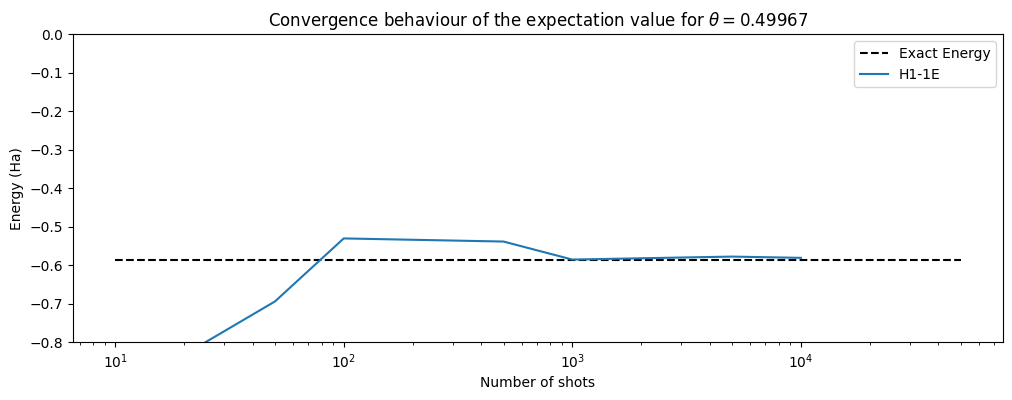

In [ ]:
import matplotlib.pyplot as plt
# we plot the results of our sampling
plt.rcParams["figure.figsize"] = (12, 4)

plt.hlines(
    y=-0.5876463677224993,
    xmin=10,
    xmax=50000,
    ls="--",
    colors="black",
    label="Exact Energy",
)
plt.plot(set_shots, noisy_H1_1E_energies, label="H1-1E")
plt.xscale("log")
plt.ylim([-0.8, 0])
plt.xlabel("Number of shots")
plt.ylabel("Energy (Ha)")
plt.title(
    "Convergence behavior of the expectation value for "
    + r"$\theta=$%.5f" % list(p.values())[0]
)
plt.legend()

### 3. Noise mitigation methods in Quantinuum emulation

We can use noise mitigation techniques to reduce the impact of noise in our expectation value. In this case we will 'purify' results by discarding a shot if it has a certain error. There are many other mitigation methods. 

Specifically, we will define the symmetries of the Qubit Operators in the system to use PMSV (Partition Measurement Symmetry Verification). As a result, noise mitigation improves the accuracy of the energy obtained from the quantum hardware compared to the unmitigated results and the exact energy of H<sub>2</sub>.

State Preparation and Measurement (SPAM) correction, which calibrates the calculation for system noise, can also be used.

In [ ]:
from inquanto.protocols.averaging._mitigation import PMSV
from inquanto.mappings import QubitMappingJordanWigner

backend = QuantinuumBackend(device_name="", label="", group="")

stabilizers = QubitMappingJordanWigner().operator_map(
    space.symmetry_operators_z2_in_sector(state)
)

mitms_pmsv = PMSV(stabilizers)

miti_H1_1E_energies = []
for i in set_shots:
    protocol = PauliAveraging(
        backend,
        shots_per_circuit=i,
        pauli_partition_strategy=PauliPartitionStrat.CommutingSets,
    )
    protocol.build(
        p, ansatz, hamiltonian.qubit_encode(), noise_mitigation=mitms_pmsv
    ).compile_circuits().run()

    miti_H1_1E_expectation = protocol.evaluate_expectation_value(
        ansatz, hamiltonian.qubit_encode()
    )
    miti_H1_1E_energies.append(miti_H1_1E_expectation)

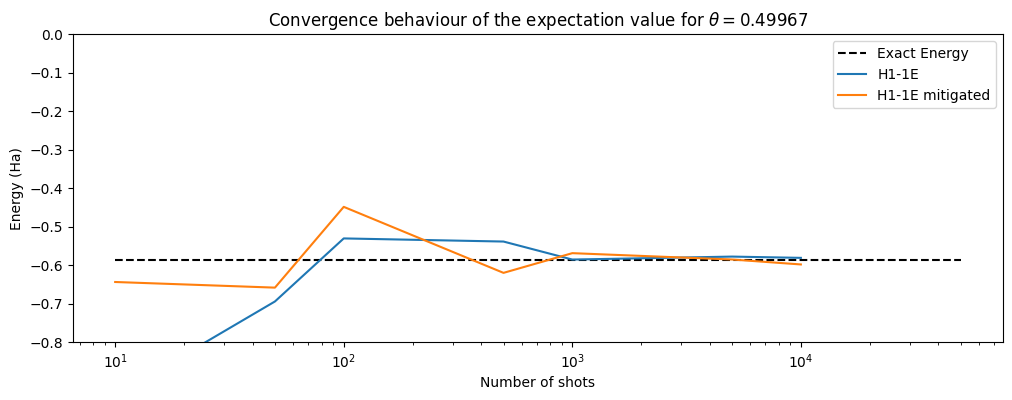

In [ ]:
#statevector 
plt.hlines(
    y=-0.5876463677224993,
    xmin=10,
    xmax=50000,
    ls="--",
    colors="black",
    label="Exact Energy",
)
plt.plot(set_shots, noisy_H1_1E_energies, label="H1-1E")
plt.plot(set_shots, miti_H1_1E_energies, label="H1-1E mitigated")
plt.xscale("log")
plt.ylim([-0.8, 0])
plt.xlabel("Number of shots")
plt.ylabel("Energy (Ha)")
plt.title(
    "Convergence behavior of the expectation value for "
    + r"$\theta=$%.5f" % list(p.values())[0]
)
plt.legend()

One may also explore the impact of SPAM on enhancing the convergence behavior of the expectation value. In the case of this simple system with a shallow circuit, the energy converges with slightly improved efficiency and/or heightened precision upon employing noise mitigation techniques.

Transitioning to hardware experiments is straightforward. This is facilitated by the `pytket.extensions.quantinuum` module. The user simply changes the device name (e.g., from "H1-1E" to "H1-1"), and the circuit will be run on the physical quantum device provided sufficient credits and circuit syntax. 